## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import emoji
import autocorrect ## Has to be installed
from textblob import TextBlob ## Has to be installed
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
## nltk.download('punkt')
from nltk.corpus import stopwords
## nltk.download('stopwords')
## nltk.download('vader_lexicon')
from nltk.stem import PorterStemmer,WordNetLemmatizer,LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
## pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score,ConfusionMatrixDisplay

## Loading the Data

In [2]:
yonex = pd.read_csv(r"C:\Users\ASUS\Documents\Innomatics Jupyter notebooks\Data Science Internship\Tasks\Sentiment Analysis on Flipkart Products\data\reviews_badminton\data.csv")

In [3]:
yonex

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...,...,...,...,...,...,...
8513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
8514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
8516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [4]:
yonex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


## Text Preprocessing

### Text Cleaning

#### Checking for Null Values

In [5]:
yonex.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [6]:
yonex['Month'].fillna(yonex['Month'].mode()[0], inplace=True)
yonex['Place of Review'].fillna(yonex['Place of Review'].mode()[0], inplace=True)
yonex['Up Votes'].fillna(yonex['Up Votes'].mean(), inplace=True)
yonex['Down Votes'].fillna(yonex['Down Votes'].mean(), inplace=True)

In [7]:
yonex.dropna(inplace=True)

In [8]:
yonex.isnull().sum()

Reviewer Name      0
Review Title       0
Place of Review    0
Up Votes           0
Down Votes         0
Month              0
Review text        0
Ratings            0
dtype: int64

#### Checking for Duplicates

In [9]:
yonex.duplicated().sum()

0

### Converting to Lower Case

In [10]:
yonex['Review text']=yonex['Review text'].str.lower()

### Removing Emojis

In [11]:
def remove_repetitive_emojis(x):
    emoji_pattern = re.compile(r"(\s*)([\U0001F600-\U0001F64F"
                               r"\U0001F300-\U0001F5FF"
                               r"\U0001F680-\U0001F6FF"
                               r"\U0001F1E0-\U0001F1FF"
                               r"\U00002500-\U00002BEF"
                               r"\U00002702-\U000027B0"
                               r"\U000024C2-\U0001F251"
                               r"\U0001f926-\U0001f937"
                               r"\U00010000-\U0010ffff"
                               r"\u2640-\u2642"
                               r"\u2600-\u2B55"
                               r"\u200d"
                               r"\u23cf"
                               r"\u23e9"
                               r"\u231a"
                               r"\ufe0f"
                               r"\u3030"
                               r"]{1,})", flags=re.UNICODE)
    cleaned_text = emoji_pattern.sub(r'\1', x)
    return cleaned_text

yonex['Review text'] = yonex['Review text'].apply(remove_repetitive_emojis)

### Tokenization

In [12]:
yonex['Review text'] = yonex['Review text'].apply(lambda x: " ".join(word_tokenize(x)))

In [13]:
yonex

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"nice product , good quality , but price is now...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,they did n't supplied yonex mavis 350. outside...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,worst product . damaged shuttlecocks packed in...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,Oct 2020,"quite o. k. , but nowadays the quality of the ...",3
4,ASHIK P A,Over priced,"Certified Buyer, Bengaluru",147.0,24.0,Apr 2016,over pricedjust â ? ¹620 .. from retailer.i di...,1
...,...,...,...,...,...,...,...,...
8503,darwin,Yones Mavis 350 Blue cap,"Certified Buyer, Bengaluru",2.0,0.0,Apr 2016,wrost and duplicate productdo n't buy this sel...,1
8504,naresh g,For Mavis350,"Certified Buyer, Bengaluru",2.0,1.0,Aug 2016,received product intact and sealedread more,5
8505,MD. Jabbar,Very Good,"Certified Buyer, Bengaluru",1.0,0.0,Sep 2016,delivered before time but price is high from m...,3
8506,Abani Behera,Don't waste your money,"Certified Buyer, Bengaluru",0.0,2.0,Sep 2016,up to the mark but same is available in market...,4


### Removing Punctuation marks and Numbers

In [14]:
def remove_punctuation_and_numbers(x):
    pattern = r'[^\w\s]|[\d]'
    cleaned_text = re.sub(pattern,'', x)
    return cleaned_text

yonex['Review text'] = yonex['Review text'].apply(remove_punctuation_and_numbers)

In [15]:
yonex

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,nice product good quality but price is now r...,4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,they did nt supplied yonex mavis outside cove...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,worst product damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,Oct 2020,quite o k but nowadays the quality of the cor...,3
4,ASHIK P A,Over priced,"Certified Buyer, Bengaluru",147.0,24.0,Apr 2016,over pricedjust â ¹ from retaileri did nt un...,1
...,...,...,...,...,...,...,...,...
8503,darwin,Yones Mavis 350 Blue cap,"Certified Buyer, Bengaluru",2.0,0.0,Apr 2016,wrost and duplicate productdo nt buy this sell...,1
8504,naresh g,For Mavis350,"Certified Buyer, Bengaluru",2.0,1.0,Aug 2016,received product intact and sealedread more,5
8505,MD. Jabbar,Very Good,"Certified Buyer, Bengaluru",1.0,0.0,Sep 2016,delivered before time but price is high from m...,3
8506,Abani Behera,Don't waste your money,"Certified Buyer, Bengaluru",0.0,2.0,Sep 2016,up to the mark but same is available in market...,4


### Removing the Stopwords

In [16]:
st=stopwords.words('english')

In [17]:
st

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
yonex

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,nice product good quality but price is now r...,4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,they did nt supplied yonex mavis outside cove...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,worst product damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,Oct 2020,quite o k but nowadays the quality of the cor...,3
4,ASHIK P A,Over priced,"Certified Buyer, Bengaluru",147.0,24.0,Apr 2016,over pricedjust â ¹ from retaileri did nt un...,1
...,...,...,...,...,...,...,...,...
8503,darwin,Yones Mavis 350 Blue cap,"Certified Buyer, Bengaluru",2.0,0.0,Apr 2016,wrost and duplicate productdo nt buy this sell...,1
8504,naresh g,For Mavis350,"Certified Buyer, Bengaluru",2.0,1.0,Aug 2016,received product intact and sealedread more,5
8505,MD. Jabbar,Very Good,"Certified Buyer, Bengaluru",1.0,0.0,Sep 2016,delivered before time but price is high from m...,3
8506,Abani Behera,Don't waste your money,"Certified Buyer, Bengaluru",0.0,2.0,Sep 2016,up to the mark but same is available in market...,4


In [19]:
yonex['Review text'] = yonex['Review text'].str.replace('â','a')

In [20]:
yonex['Review text'] = yonex['Review text'].str.replace('¹','')

In [21]:
yonex['Review text']

0       nice product  good quality  but price is now r...
1       they did nt supplied yonex mavis  outside cove...
2       worst product  damaged shuttlecocks packed in ...
3       quite o k  but nowadays the quality of the cor...
4       over pricedjust a    from retaileri did nt und...
                              ...                        
8503    wrost and duplicate productdo nt buy this sell...
8504          received product intact and sealedread more
8505    delivered before time but price is high from m...
8506    up to the mark but same is available in market...
8507                         nice delivery speedread more
Name: Review text, Length: 8508, dtype: object

In [22]:
def remove_stopwords(text):
  """
  This function removes stopwords from a string.

  Args:
      text: The string to remove stopwords from.

  Returns:
      A string without stopwords.
  """
  return ' '.join([word for word in text.split() if word not in st])

In [23]:
yonex['Review text'] = yonex['Review text'].apply(remove_stopwords)

## Text Normalization

### Lemmatization

In [25]:
lemma=WordNetLemmatizer()

In [26]:
from nltk.stem import WordNetLemmatizer
lemma=WordNetLemmatizer()
def lemmatizer(x):
    lemmatized = [lemma.lemmatize(i) for i in x]
    return "".join(lemmatized)

yonex['Review text'] = yonex['Review text'].apply(lemmatizer)

In [27]:
yonex

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,nice product good quality price rising bad sig...,4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,nt supplied yonex mavis outside cover yonex ad...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,worst product damaged shuttlecocks packed new ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,Oct 2020,quite k nowadays quality corks like years back...,3
4,ASHIK P A,Over priced,"Certified Buyer, Bengaluru",147.0,24.0,Apr 2016,pricedjust retaileri nt understand wat advanta...,1
...,...,...,...,...,...,...,...,...
8503,darwin,Yones Mavis 350 Blue cap,"Certified Buyer, Bengaluru",2.0,0.0,Apr 2016,wrost duplicate productdo nt buy seller produc...,1
8504,naresh g,For Mavis350,"Certified Buyer, Bengaluru",2.0,1.0,Aug 2016,received product intact sealedread,5
8505,MD. Jabbar,Very Good,"Certified Buyer, Bengaluru",1.0,0.0,Sep 2016,delivered time price high marketread,3
8506,Abani Behera,Don't waste your money,"Certified Buyer, Bengaluru",0.0,2.0,Sep 2016,mark available market less priceread,4


### Correcting Spellings

In [28]:
def texty(x):
    txt=TextBlob(x)
    return str(txt.correct())

In [29]:
texty(yonex['Review text'][8503])

'wrist duplicate produced it buy seller productflipkart to seller to block or den chahiyeread'

In [30]:
yonex['Review text'] = yonex['Review text'].apply(texty)

In [31]:
yonex

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,nice product good quality price rising bad sig...,4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,it supplied one davis outside cover one ad ins...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,worst product damaged shuttlecocks packed new ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,Oct 2020,quite k nowadays quality corks like years back...,3
4,ASHIK P A,Over priced,"Certified Buyer, Bengaluru",147.0,24.0,Apr 2016,pricedjust retailer it understand wat advantag...,1
...,...,...,...,...,...,...,...,...
8503,darwin,Yones Mavis 350 Blue cap,"Certified Buyer, Bengaluru",2.0,0.0,Apr 2016,wrist duplicate produced it buy seller product...,1
8504,naresh g,For Mavis350,"Certified Buyer, Bengaluru",2.0,1.0,Aug 2016,received product intact sealedread,5
8505,MD. Jabbar,Very Good,"Certified Buyer, Bengaluru",1.0,0.0,Sep 2016,delivered time price high marketread,3
8506,Abani Behera,Don't waste your money,"Certified Buyer, Bengaluru",0.0,2.0,Sep 2016,mark available market less priceread,4


In [ ]:
yonex.to_csv('yonex.csv',index=False)

## Numerical Feature Extraction

In [35]:
vector = CountVectorizer()

In [36]:
vector.fit_transform(yonex['Review text']).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

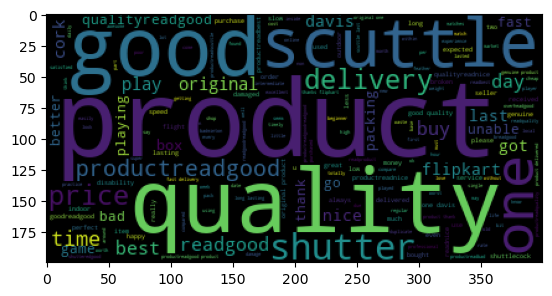

In [37]:
text = "".join(yonex['Review text'].values.tolist())
data=WordCloud().generate(text)
plt.imshow(data)

In [38]:
analyzer = SentimentIntensityAnalyzer()

In [39]:
def polarity(n):
    return analyzer.polarity_scores(n)['compound']

In [65]:
yonex['Emotion'] = yonex['Review text'].apply(polarity)

In [66]:
yonex['Emotion']

0       0.9110
1      -0.4767
2      -0.8591
3       0.8979
4       0.2500
         ...  
8503   -0.4404
8504    0.2023
8505    0.0000
8506    0.0000
8507    0.4215
Name: Emotion, Length: 8508, dtype: float64

In [68]:
def sentiment(n):
    if n <= 0.3:
        return 'Negative'
    else:
        return 'Positive'

In [69]:
yonex['Emotion'] = yonex['Emotion'].apply(sentiment)

<Axes: >

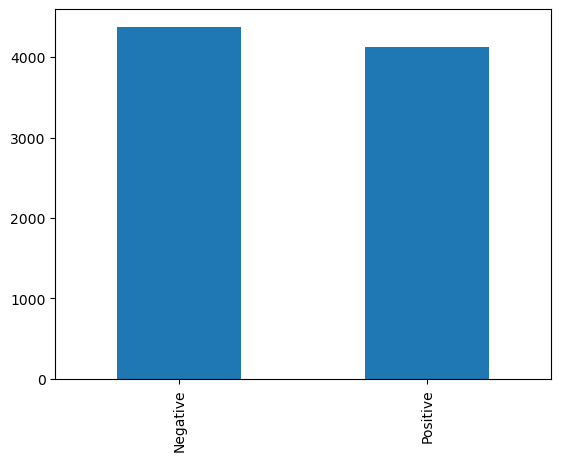

In [70]:
yonex['Emotion'].value_counts().plot(kind = 'bar')

In [71]:
df = pd.concat([yonex['Review text'],yonex['Emotion']],axis=1)

In [72]:
df

,Review text,Emotion
0,nice product good quality price rising bad sig...,Positive
1,it supplied one davis outside cover one ad ins...,Negative
2,worst product damaged shuttlecocks packed new ...,Negative
3,quite k nowadays quality corks like years back...,Positive
4,pricedjust retailer it understand wat advantag...,Negative
...,...,...
8503,wrist duplicate produced it buy seller product...,Negative
8504,received product intact sealedread,Negative
8505,delivered time price high marketread,Negative
8506,mark available market less priceread,Negative


In [73]:
df['Emotion'].value_counts()

Negative    4378
Positive    4130
Name: Emotion, dtype: int64

In [74]:
X=df['Review text']
y=df['Emotion']

In [75]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [76]:
pipe=Pipeline([('Vectorization',CountVectorizer(stop_words='english')),
              ("Estimator",MultinomialNB(alpha=3))])

In [77]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('Vectorization', CountVectorizer(stop_words='english')),
                ('Estimator', MultinomialNB(alpha=3))])

In [78]:
y_pred = pipe.predict(X_test)

In [79]:
accuracy_score(y_test,y_pred)

0.9030552291421856

In [80]:
f1_score(y_test, y_pred, average='weighted')

0.902649272479265

In [83]:
pipe.predict(['Waste Product'])

array(['Negative'], dtype='<U8')

### Creating a pickle file

In [84]:
import pickle
pickle.dump(pipe,open("sentiment_yonex.pkl","wb"))

In [85]:
import os
os.getcwd()

'C:\\Users\\ASUS\\Documents\\Innomatics Jupyter notebooks\\Data Science Internship\\Tasks\\Sentiment Analysis on Flipkart Products'

In [86]:
predict = pickle.load(open("sentiment_yonex.pkl","rb"))

In [87]:
predict.predict(['This is so good'])[0]

'Positive'

In [88]:
predict.predict(['This is a bad product'])[0]

'Negative'